In [ ]:
# installing pytorch lightning and transformer
! pip install --quiet lightning
! pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 38.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# importing all necessary packages
from os import listdir
from os.path import join
from sklearn.model_selection import train_test_split
import string
from torch.utils.data import Dataset, DataLoader
import torch
import torchmetrics
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/BT5151/Group project'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/BT5151/Group project
/content/gdrive/My Drive/BT5151/Group project


In [ ]:
%run tokenizer_class.py

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
from tokenizer_class import tokenize_text_with_labels

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
reviews_df = pd.read_csv('reviews_df.csv')

In [ ]:
reviews_df.head()

,ProductId,UserId,Score,Time_ymd,Summary_Text,Clean_Text,Original_Text_Length,Clean_Text_Length,Helpfulness_Ratio,Sentiment,NumUniqueProducts,Days_since_last_review,polarity,subjectivity
0,B001E4KFG0,A3SGXH7AUHU8GW,5,2011-04-27,Good Quality Dog Food I have bought several of...,good quality food bought several vitality cann...,285,162,1.0,1,1,248,0.480000,0.440000
1,B000UA0QIQ,A395BORC6FGVXV,2,2011-06-13,Cough Medicine If you are looking for the secr...,cough medicine looking secret ingredient robit...,234,139,1.0,-1,3,201,0.150000,0.650000
2,B000E7L2R4,A1MZYO9TZK0BBI,5,2011-11-23,Yay Barley Right now I'm mostly just sprouting...,barley right mostly sprouting cats grass love ...,142,70,1.0,1,2,37,0.428571,0.545238
3,B001GVISJM,A2A9X58G2GTBLP,5,2011-12-23,"GREAT SWEET CANDY! Twizzlers, Strawberry my ch...",great sweet candy twizzlers strawberry childho...,765,492,-1.0,1,44,8,0.271429,0.550000
4,B001GVISJM,A3IV7CL2C13K2U,5,2011-10-08,Home delivered twizlers Candy was delivered ve...,home delivered twizlers candy delivered fast p...,169,103,-1.0,1,1,84,0.225000,0.675000


In [ ]:
reviews_df.shape

(161599, 14)

In [ ]:
sentences = reviews_df['Summary_Text']
# from keras.utils import to_categorical
labels = reviews_df['Sentiment']

# Adjust labels to start from 0
labels_adjusted = labels + 1

# Convert adjusted labels to categorical format
categorical_labels = to_categorical(labels_adjusted)

# Example usage:
print(categorical_labels)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
# Train-test-split
X_train, X_val, y_train, y_val = train_test_split(sentences, categorical_labels, test_size=0.2, stratify= categorical_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# Tokenization
max_len = 562
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

# Encoding of Inputs
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

Vocab Size:  65618


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 100
heads = 2
neurons = 32
maxlen = 562
vocab_size =  65618

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = outputs = layers.Dense(3, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras import metrics
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='categorical_crossentropy', metrics=[metrics.F1Score(average='weighted'),metrics.Precision(),metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 562)]             0         
                                                                 
 token_and_position_embeddi  (None, 562, 100)          6618000   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 562, 100)          87632     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 100)               0     

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint("best_model.h5",
                            monitor="val_f1_score",
                            mode="max",
                            save_best_only=True,
                            dirpath= '/content/gdrive/My Drive/BT5151/Group project',  # Directory to save the checkpoints
                            verbose=1)
#earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

# #learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                             patience=3,
#                                             verbose=1,
#                                             factor=0.2,
#                                             min_lr=0.00000001)

In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=4,
                    batch_size=32,
                    callbacks=[checkpoint])

Epoch 1/4
4039/4040 [============================>.] - ETA: 0s - loss: 0.3640 - f1_score: 0.8534 - precision_3: 0.8887 - recall_3: 0.8469
Epoch 1: val_f1_score improved from -inf to 0.89361, saving model to best_model.h5
4040/4040 [==============================] - 137s 33ms/step - loss: 0.3640 - f1_score: 0.8534 - precision_3: 0.8887 - recall_3: 0.8469 - val_loss: 0.2936 - val_f1_score: 0.8936 - val_precision_3: 0.9082 - val_recall_3: 0.8869
Epoch 2/4
4038/4040 [============================>.] - ETA: 0s - loss: 0.2354 - f1_score: 0.9106 - precision_3: 0.9276 - recall_3: 0.9004
Epoch 2: val_f1_score improved from 0.89361 to 0.90058, saving model to best_model.h5
4040/4040 [==============================] - 63s 16ms/step - loss: 0.2353 - f1_score: 0.9106 - precision_3: 0.9277 - recall_3: 0.9004 - val_loss: 0.2772 - val_f1_score: 0.9006 - val_precision_3: 0.9077 - val_recall_3: 0.8897
Epoch 3/4
4039/4040 [============================>.] - ETA: 0s - loss: 0.1908 - f1_score: 0.9288 - preci

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay

y_test_labels = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test_labels, y_pred_classes,average='weighted')
print('Precision: {:.2f}%'.format(precision))
recall = recall_score(y_test_labels, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format( recall))
f1 = f1_score(y_test_labels, y_pred_classes,average='weighted')
print('F1_score: {:.2f}%'.format(f1))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test_labels,y_pred_classes))

505/505 [==============================] - 2s 4ms/step
Precision: 0.90%
Recall: 0.90%
F1_score: 0.90%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2472
           1       0.57      0.58      0.57      1289
           2       0.96      0.95      0.95     12399

    accuracy                           0.90     16160
   macro avg       0.78      0.78      0.78     16160
weighted avg       0.90      0.90      0.90     16160



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# Define the TokenAndPositionEmbedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Load the saved model
best_model = load_model("/content/gdrive/My Drive/BT5151/Group project/best_model.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerEncoder": TransformerEncoder})



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score ,classification_report, RocCurveDisplay

y_test_labels = np.argmax(y_test, axis=1)
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test_labels, y_pred_classes,average='weighted')
print('Precision: {:.2f}%'.format(precision))
recall = recall_score(y_test_labels, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format( recall))
f1 = f1_score(y_test_labels, y_pred_classes,average='weighted')
print('F1_score: {:.2f}%'.format(f1))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test_labels,y_pred_classes))

505/505 [==============================] - 3s 4ms/step
Precision: 0.90%
Recall: 0.91%
F1_score: 0.91%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      2472
           1       0.61      0.52      0.56      1289
           2       0.95      0.97      0.96     12399

    accuracy                           0.91     16160
   macro avg       0.80      0.77      0.78     16160
weighted avg       0.90      0.91      0.91     16160



In [ ]:
sentiment =  list(reviews_df['Sentiment'].unique())
sentiment

[1, -1, 0]

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shap
# Store the text samples in a list
text_samples = []
X_batch = X_test[:100]
# Loop through each sequence in X_batch
for sequence in X_batch:
    # Convert integer sequences back to original text
    text = tokenizer.sequences_to_texts([sequence])[0]
    # Append the text to the list
    text_samples.append(text.lower())

# Convert the list of text samples to a numpy array
text_samples_array = np.array(text_samples)
# Subsample the background data
subsampled_data = shap.sample(X_train, 250)

# Create the explainer using the subsampled data

# Assuming best_model and X_train are defined
explainer = shap.KernelExplainer(best_model.predict,subsampled_data)

# Compute SHAP values
shap_values = explainer.shap_values(X_batch)


8/8 [==============================] - 0s 6ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

24782/24782 [==============================] - 127s 5ms/step


In [ ]:
# Assuming shap_values is a NumPy array
shap_values_file_3 = "shap_values_3.npy"

# Save SHAP values to a NumPy binary file
np.save(shap_values_file_3, shap_values)

In [ ]:
shap_values

array([[[ 0.00000000e+00,  3.30752956e-02, -3.47167199e-02],
        [ 8.40484865e-03,  1.18447244e-02, -2.58459949e-02],
        [ 0.00000000e+00, -6.34975418e-03,  8.50719986e-03],
        ...,
        [ 7.83451567e-03,  0.00000000e+00, -8.41668672e-03],
        [ 0.00000000e+00,  2.04166120e-03,  0.00000000e+00],
        [-7.46722924e-03, -1.46299629e-03,  8.36318360e-03]],

       [[-2.59057742e-02, -2.49143984e-02,  5.12660615e-02],
        [-4.46588347e-03,  2.34180499e-03,  1.78833489e-03],
        [ 3.53778245e-03,  2.37825433e-03, -6.12901181e-03],
        ...,
        [ 4.68670063e-04, -1.71308241e-03,  1.21488169e-03],
        [ 1.61213578e-03,  0.00000000e+00, -1.47662660e-03],
        [ 4.61657089e-04, -3.23673742e-04, -4.83482162e-04]],

       [[-2.60828862e-02, -1.21489239e-02,  3.80774074e-02],
        [-2.87252909e-02, -1.99344855e-02,  4.88946327e-02],
        [-4.06280016e-03, -3.96107089e-03,  7.80670190e-03],
        ...,
        [ 0.00000000e+00,  2.43710174e-04,

In [ ]:
shap_values_file = "shap_values_3.npy"

# Load the saved SHAP values from the file
shap_values = np.load(shap_values_file)

In [ ]:
# Assuming shap_values is of shape (num_instances, num_features)
# Aggregate SHAP values
aggregated_shap_values = np.mean(np.abs(shap_values), axis=0)  # Aggregate SHAP values across instances

# Flatten the aggregated SHAP values array if needed
aggregated_shap_values_flat = np.ravel(aggregated_shap_values)

# Map SHAP values to tokens
token_shap_values = list(zip(tokenizer.index_word.values(), aggregated_shap_values_flat))

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
# Define a list of stop words
stop_words = set(stopwords.words('english'))

# Additional words to add to the stop words list
additional_stop_words = ["br", "href", "amazon", "product", "counter","like"]

# Update the stop words list with additional words
stop_words.update(additional_stop_words)

# Filter out stop words from token_shap_values
filtered_token_shap_values = [(token, shap_value) for token, shap_value in token_shap_values if token.lower() not in stop_words]

# Sort filtered tokens by absolute SHAP values
sorted_token_shap_values = sorted(filtered_token_shap_values, key=lambda x: abs(x[1]), reverse=True)
sorted_token_shap_values[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('taste', 0.008035335111444964),
 ('quality', 0.007928460973255643),
 ('healthy', 0.007771488492665592),
 ('best', 0.007423515334606435),
 ('tea', 0.007324628698403685),
 ('perfect', 0.007292998805141695),
 ('price', 0.007087304675709211),
 ('good', 0.006976304619518548),
 ('made', 0.006944275518892599),
 ('treat', 0.006702182273814881)]

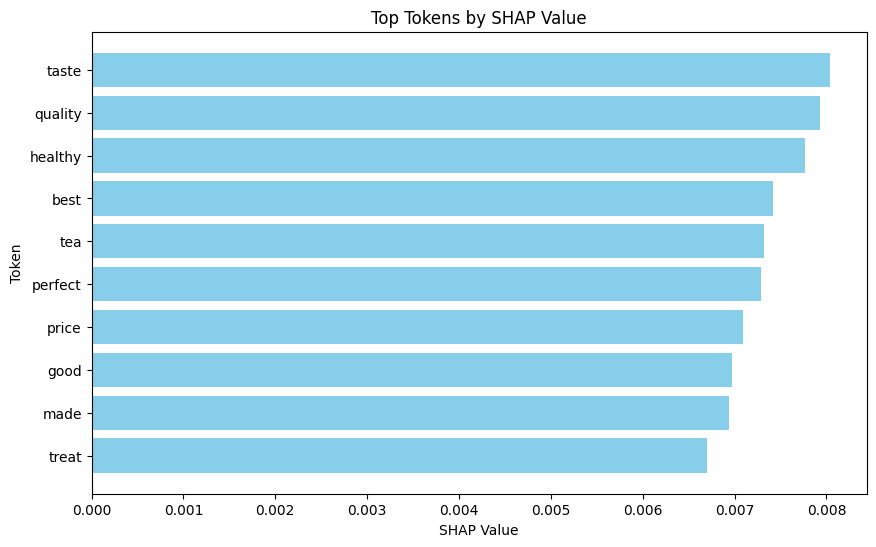

In [ ]:
import matplotlib.pyplot as plt
top_n = 10  # Number of top tokens to display
# Extract top N tokens and their SHAP values excluding stopwords
top_tokens = [token for token, _ in sorted_token_shap_values[:top_n]]
top_shap_values = [shap_value for _, shap_value in sorted_token_shap_values[:top_n]]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_tokens, top_shap_values, color='skyblue')
plt.xlabel('SHAP Value')
plt.ylabel('Token')
plt.title('Top Tokens by SHAP Value')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest SHAP value on top
plt.show()


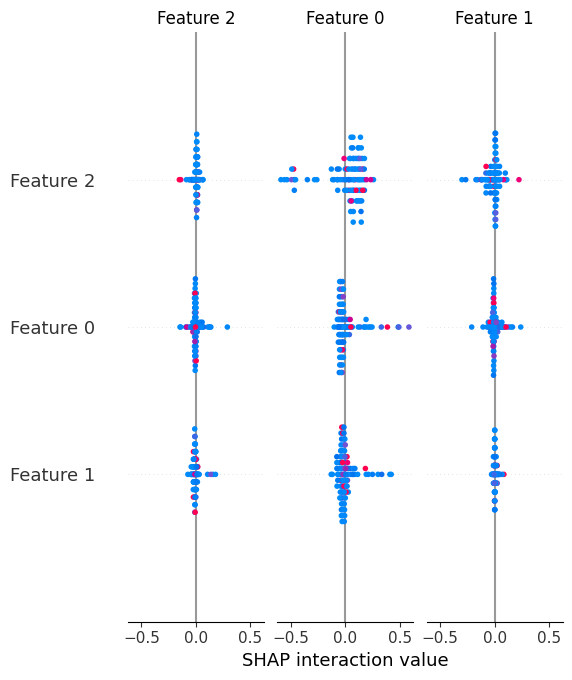

In [ ]:
X_batch = X_test[:100]


# Assuming shap_values is already computed
shap.summary_plot(shap_values, X_batch)


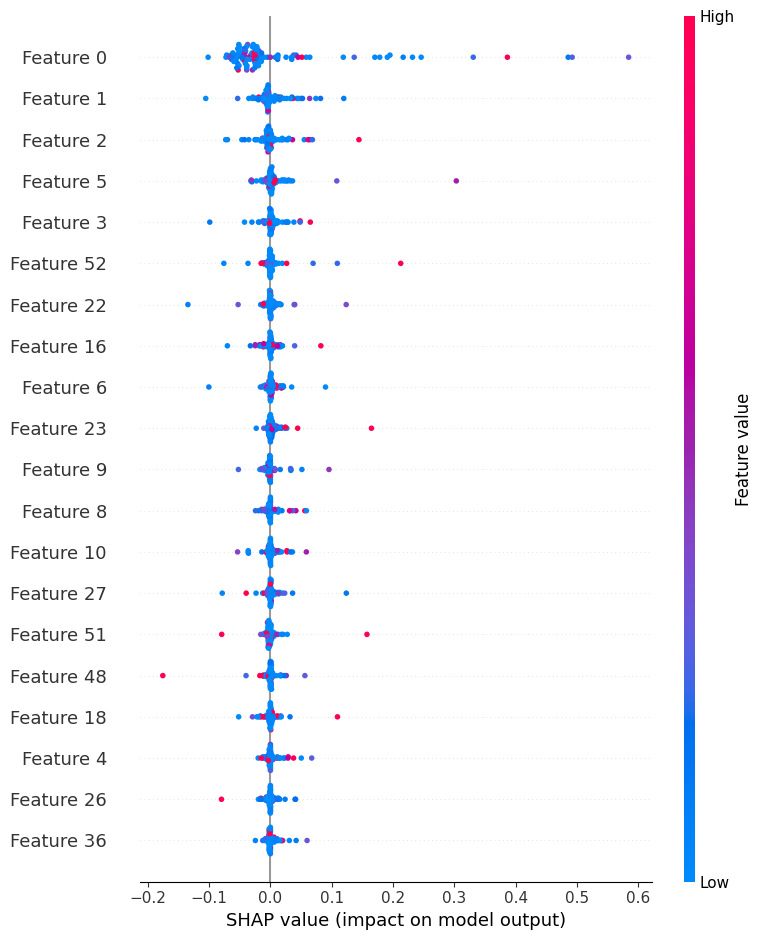

In [ ]:
class_0_shap_values = shap_values[:, :, 0]  # SHAP values for class -1
class_1_shap_values = shap_values[:, :, 1]  # SHAP values for class 0
class_2_shap_values = shap_values[:, :, 2]  # SHAP values for class 1

shap.summary_plot(class_0_shap_values, X_batch)

In [ ]:
# Extract tokens from filtered_token_shap_values
features = [token for token, _ in filtered_token_shap_values]

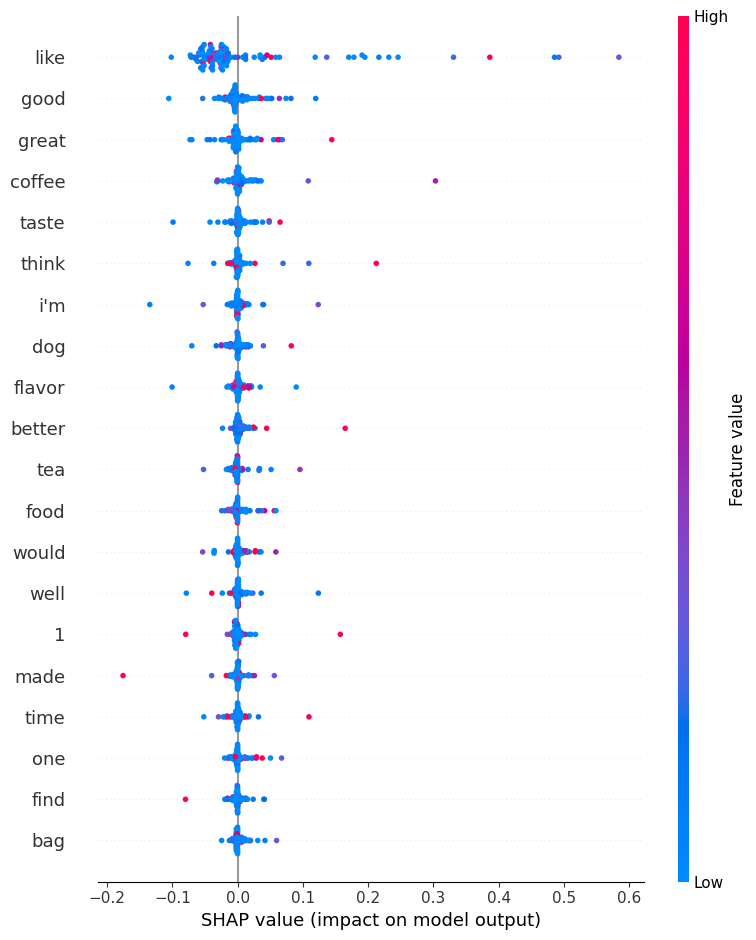

In [ ]:
# Class: -1 , score of <3
shap.summary_plot(class_0_shap_values, X_batch, feature_names=features)

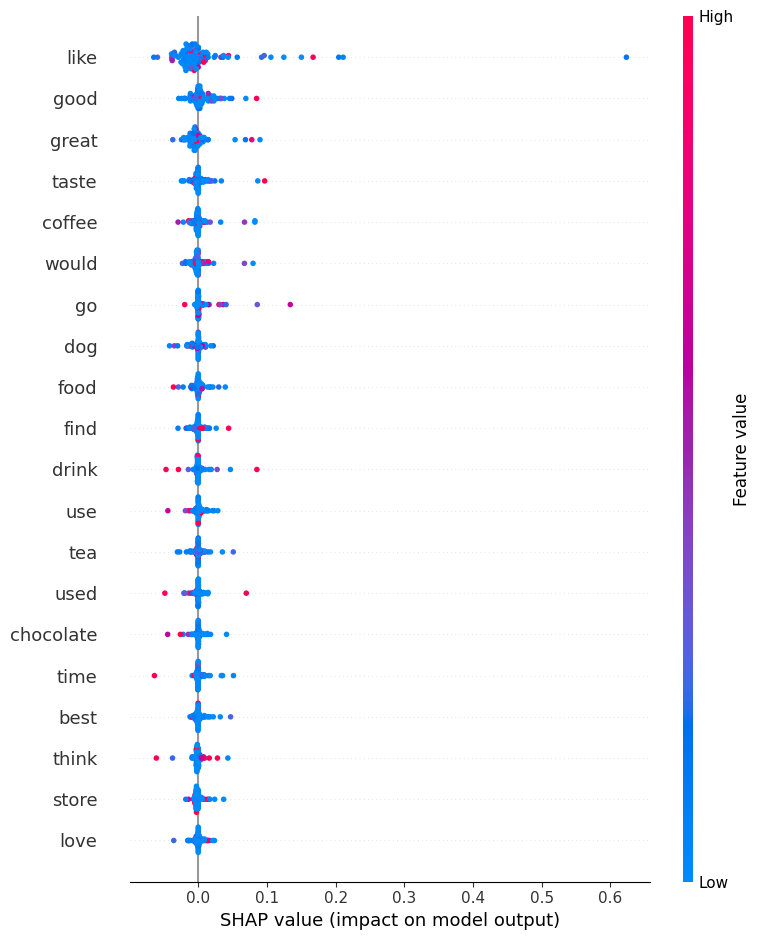

In [ ]:
# Class: 0 , score ==3
shap.summary_plot(class_1_shap_values, X_batch, feature_names=features)


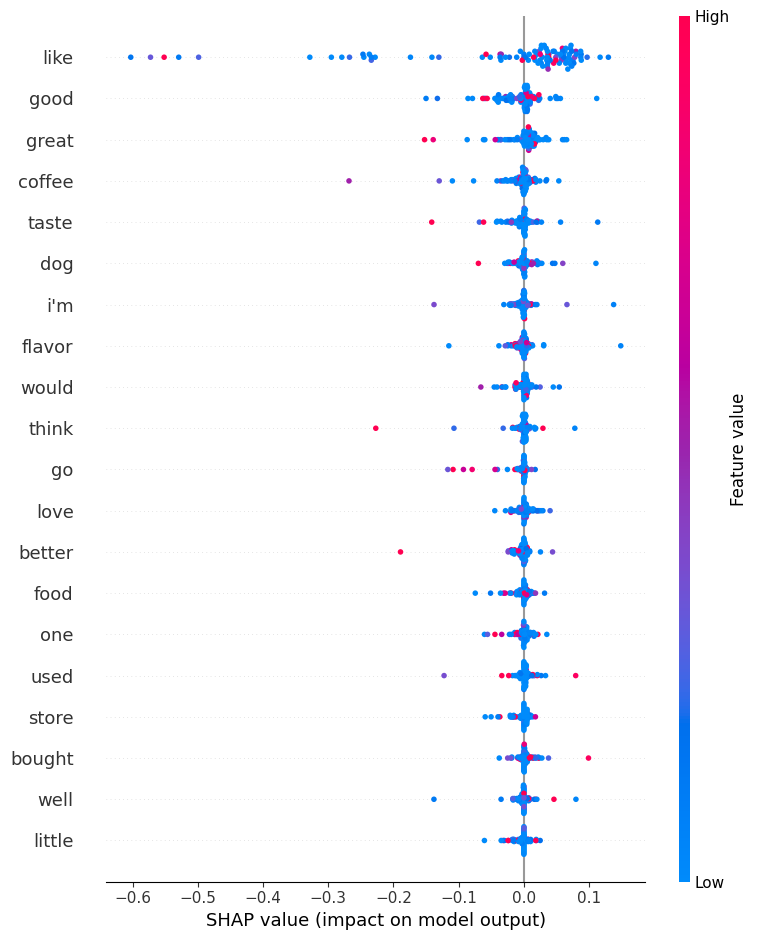

In [ ]:
# Class: 1, score > 3
shap.summary_plot(class_2_shap_values, X_batch, feature_names=features)